In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; 
from matplotlib.colors import LogNorm, Normalize
from scipy.signal import butter, lfilter, freqz,detrend
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from scipy import constants
#sns.set_theme()
import re
import utils
from scipy import ndimage
from scipy.signal import lfilter

import cv2

In [3]:
c = constants.c
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
frame_rate =50*10**(-3) # frame rate
sample_per_frame = 260*257 # sample pr frame
c_t = (1/sample_bandwidth )*256 # sample period
#fs_new = 1/sample_period_new # sample frekuenzy 

In [4]:
plot_min_range = 40
plot_max_range = 120
plot_min_doppler = 100
plot_max_doppler = 150
plot_min_3d = 80
plot_max_3d = 95

# Functions

In [18]:
def simple_exp_smooth(d,extra_periods=1,alpha=0.4):  
  #d = np.array(d)  # Transform the input into a numpy array  
  cols = len(d)  # Historical period length  
  #d = np.append(d,[np.nan]*extra_periods)  # Append np.nan into the demand array to cover future periods  
  f = np.zeros_like(d)  # Forecast array  
  f[0] = d[0]  # initialization of first forecast  
 
  # Create all the t+1 forecasts until end of historical period  
  for t in range(1,cols):  
    f[t] = alpha*d[t]+(1-alpha)*f[t-1]
  #print(f)  
  f[cols+1:] = f[t]  # Forecast for all extra periods  
  #df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f})
  return f,d

In [19]:
def background_update(frames, alpha=1/128, nr_of_ma=1,window=1):
    fft_length = 256
    MRDM =np.zeros((len(frames),fft_length,fft_length),dtype=np.complex_)
    
    for i,frame in enumerate(frames):
        length = int.from_bytes(
                 frame[4:8], byteorder="little", signed=False)
        
        data_RADC = frame[8:8+length]
        data_RADC = np.frombuffer(data_RADC,dtype=np.uint16)
        data_RADC = data_RADC.reshape(3,256,512)
        data_RADC_I_raw = data_RADC[:,:,::2]
        data_RADC_Q_raw = data_RADC[:,:,1::2]
        data_RADC_I = detrend(data_RADC_I_raw, axis=2)
        data_RADC_Q = detrend(data_RADC_Q_raw, axis=2)
        #window = signal.windows.chebwin(256, 100, sym=True)#signal.windows.hann(256)
        #data_RADC_I_mean = np.mean(data_RADC_I, axis=0)
        #data_RADC_Q_mean = np.mean(data_RADC_Q, axis=0)
        data_RADC_I_mean = data_RADC_I[0]
        data_RADC_Q_mean = data_RADC_Q[0]
        data_IF = window*data_RADC_I_mean[:,:] + window*1j*data_RADC_Q_mean[:,:]
       

        data_range_baseline =utils.fft_and_plot(data_IF, axis=1, fs=sample_frek,fft_size=fft_length,plot=False,shift =False)
        data_range_baseline = utils.MIT_filter( data_range_baseline)
        for j in range(fft_length):
             data_range_baseline[:,j] = window*data_range_baseline[:,j]
        data_range_baseline = utils.MIT_filter( data_range_baseline)
        data_doppler_window_slow= utils.fft_and_plot(data_range_baseline, axis=0,fft_size=fft_length,shift =True)
     
        #MRDM[i]=cv2.GaussianBlur(np.abs(data_doppler_window_slow) ,(3, 3),sigmaX=1,sigmaY=1)
        MRDM[i] = data_doppler_window_slow

    #MIT
   
   
    data_diff = MRDM.copy()
    raw_frames = MRDM.copy()
    for i in range(nr_of_ma):
        MRDM,frames =simple_exp_smooth(data_diff,alpha =alpha)
        data_diff = np.abs(frames) -np.abs(MRDM)
        print("MA",i)
    #data_diff = np.abs(frames[-1]) -np.abs(MRDM[-2])
    utils.CFAR_2D(data_diff[-1].copy(),10, 15, 0.000001,plot=False, iso_axis=True)
    return MRDM,raw_frames,data_diff

# The Radar Range Equation

## Noise floor

In [25]:
def kph_to_doppler_shift(kph, wavelength):
  c = 299792458 # speed of light in meters per second
  v= kph / 3.6
  f_d = 2*v/wavelength
  return f_d

In [41]:
PRF = 2*kph_to_doppler_shift(30,0.012426)
PRF

2682.547346960674

In [27]:
velocity_res = 0.23622712
wavelength = 0.012426
doppler_res = kph_to_doppler_shift(velocity_res,wavelength)
doppler_res

10.561507233936013

In [52]:
T=1/doppler_res
T*256

24.238964603217447

In [61]:
n=256
sample_bandwidth  = 191.0153846e6
sample_frek = 2*sample_bandwidth # sample frekuenzy
PRI=1/PRF
print(1/sample_frek*256)
T_D = n*PRI
B = 191.0153846e6
T_D

6.701030928374761e-07


0.09543167999999999

In [136]:
N = constants.Boltzmann*290*10**(5/10)*B
print(10*np.log10(N*10**3))
print(20*np.log10(N))






-86.16450372186532
-232.32900744373063


In [137]:
#The radar equation
def recived_power(r):
    eirp = 10**(19/10)/1000
    G= 10**(15/10)
    wavelength = 0.012426
    sigma = 50

    pr = eirp*G*wavelength**2*sigma/((4*np.pi)**3*r**4)
    return pr

In [138]:
10*np.log10(recived_power(77)*10**3)

-95.55959789866006

In [75]:
files = {
   "no_reflector": "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin",
    "reflector":"felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin",
    "munkholm":"felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin",
    }
try:
        #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
        #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
        with open(files["reflector"], "rb") as f:

            data = f.read()
        
            
            
except IOError as e:
        print(e)

stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
    ls = re.search(stri.encode(), data_bytes).end()
    data_arr.append(data_bytes[:ls])
    data_bytes = data_bytes[ls+4:]
    print(len(data_bytes))
    if(len(data_bytes) == 0):
        done = True

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


In [134]:
def plot_pr_vs_tho_pr(file,file_name,window,nr_of_ma,alpha,start_bin,end_bin,slice_start,slice_end):
    
    data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
        nr_of_ma, alpha=alpha,window = window)

    plt.figure()
    start_bin =start_bin
    end_bin = end_bin

    detections =np.max(np.abs(data_diff),axis=0)
    detections  = ndimage.rotate(detections,90)
    detection_line = np.abs(np.max(detections[start_bin:end_bin,slice_start:slice_end],axis=1))
    detection_line = np.abs(detections[start_bin:end_bin,87])
    mean_n = np.mean(np.abs(detections[start_bin:end_bin,50]))
    corection = mean_n-N
    
    noise_floor = np.abs(detections[start_bin:end_bin,50])-corection
    detection_line_corr = detection_line-corection
    print("the N",20*np.log10(N))
    #print("Observed",20*np.log10(np.mean(np.abs(noise_floor))))
    
    r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
    print(20*np.log10(N))
    pr = recived_power(r)
    print(20*np.log10(pr))
    plt.hlines(20*np.log10(N),xmin = start_bin,xmax=end_bin, label="Theoretical noise floor")
    plt.plot(20*np.log10(pr),label="Theoretical recived power")
    plt.plot(20*np.log10(np.abs(detection_line_corr)),label="5.1 kt bin")
    plt.plot(20*np.log10(noise_floor),label="Noise floor")

    plt.legend()
    #plt.title("",size=25)
    #plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
    plt.yticks(size=15)
    plt.xlabel("Range [m]",size=20)
    plt.ylabel("Magnitude",size=20)
    plt.tight_layout()
    plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
    plt.gca().invert_xaxis()

the N -232.32900744373063
[-254.18846532 -254.0505237  -253.91203222 -253.7729865  -253.63338207
 -253.49321442 -253.352479   -253.21117118 -253.0692863  -252.92681961
 -252.78376632 -252.6401216  -252.49588051 -252.3510381  -252.20558933
 -252.0595291  -251.91285224 -251.76555354 -251.61762768 -251.46906932
 -251.31987301 -251.17003326 -251.01954448 -250.86840105 -250.71659722
 -250.56412721 -250.41098515 -250.25716508 -250.10266097 -249.94746672
 -249.79157612 -249.63498291 -249.47768072 -249.31966309 -249.1609235
 -249.00145532 -248.84125182 -248.6803062  -248.51861154 -248.35616084
 -248.19294701 -248.02896282 -247.86420099 -247.69865409 -247.53231462
 -247.36517494 -247.19722731 -247.0284639  -246.85887673 -246.68845773
 -246.51719869 -246.34509129 -246.17212708 -245.9982975  -245.82359383
 -245.64800725 -245.47152878 -245.29414931 -245.11585961 -244.93665027
 -244.75651177 -244.57543441 -244.39340837 -244.21042364 -244.02647008
 -243.84153736 -243.65561502 -243.46869241 -243.2807

/Users/sondreolimb/prosjektOppgave/ProjectReportCode/env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


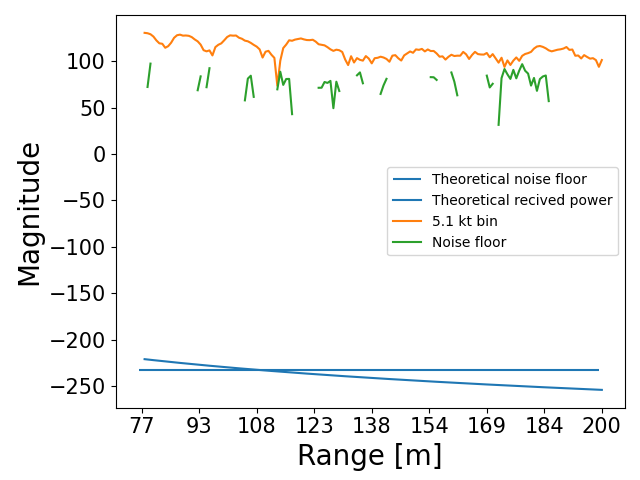

In [135]:

plot_pr_vs_tho_pr("reflector","reflector",nr_of_ma=0,window=1,alpha = 1/256,start_bin=1,end_bin=157,slice_start =100,slice_end=500)

# SNR

In [7]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def all_cfar(data_arr, nr_of_ma=0, alpha=1/256, mode="nearest",window=1 ,plot=False,saveFig=False,FileName="CFAR"):
    data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
        nr_of_ma, alpha=alpha,window = window)
    
    cfar_array= []
    SNR_array = []
    SNR_D_array = []
    length_data_diff = len(data_diff[1:-1])
    for i,img in enumerate( data_diff[1:-1]):
        cfar ,y,SNR,d= utils.CFAR_2D(img,10, 15, 0.000001,plot=False, iso_axis=True)
        cfar_array.append(cfar)
        
        SNR_array.append(SNR)
        SNR_D_array.append(y)
        print(np.round(i/length_data_diff*100,1))

    labels = {
    "x_label":"Velocity [knots]",
    "y_label":"Range [m]",
    "title": "All CFAR detections"

}
    
    test = np.max(np.abs(cfar_array),axis=0)
    #test[test < 1.1] =0
    #test[test>1] =1
    plt.figure(figsize=(10,10))
    print(np.shape(test))
    rotated_img =20*np.log10(np.abs(test)) # We rotate the image so the x axis is the velocity
    ax = plt.gca()
    #cmap = mpl.colors.ListedColormap(['darkBlue','red'])
    #bounds=[-0,1]
    #norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    
    #plt.imshow(rotated_img,interpolation='nearest',cmap = cmap,norm=norm)
    plt.imshow(rotated_img,interpolation='nearest',cmap = "plasma",vmin=100,vmax=160)
    plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
    plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar  = plt.colorbar(cax=cax)
    
    cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
    cbar.ax.tick_params(labelsize=15) 
    plt.xlabel(labels["x_label"],fontdict = {'fontsize' : 20})
    plt.ylabel(labels["y_label"],fontdict = {'fontsize' : 20})
    #plt.title(labels["title"],fontdict = {'fontsize' : 30})
    plt.grid(False)
    if saveFig:
        plt.savefig(f"cfar_io/munkholm_{FileName}.svg",format="svg")
    plt.show()
    return cfar_array,SNR_D_array,data_diff ,SNR_array

In [46]:
def plot_log_snr_and_PR(file,save_filename,nr_of_ma=0,window=signal.windows.chebwin(256,300),start=1,end=1,width_min = 86,width_max=88,slice_start =100,slice_end=500,cfar = False):
    files = {
   "no_reflector": "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin",
    "reflector":"felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin",
    "munkholm":"felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin",
    }
    try:
        #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
        #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
        with open(files[file], "rb") as f:

            data = f.read()
        
            
            
    except IOError as e:
        print(e)

    stri = "DONE"
    done = False
    data_arr = []
    index = 0
    data_bytes = data
    while(not done):
        ls = re.search(stri.encode(), data_bytes).end()
        data_arr.append(data_bytes[:ls])
        data_bytes = data_bytes[ls+4:]
        print(len(data_bytes))
        if(len(data_bytes) == 0):
            done = True
   
    data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
        nr_of_ma, alpha=1/256,window = window)     
    
    cfar,SNR_D_arr,data_diff,SNR_array=all_cfar(data_arr[slice_start:slice_end], nr_of_ma=nr_of_ma, alpha=1/256, mode="nearest",window = window ,plot=False,saveFig=True,FileName=save_filename)



        ### plot SNR
    plt.figure()
    start_bin =start
    end_bin = end

    detections =np.max(np.abs(SNR_D_arr),axis=0)
    #detections  = ndimage.rotate(detections,90)
    detection_line = np.abs(np.max(detections[start_bin:end_bin,width_min:width_max],axis=1))
    #detection_line = np.abs(detections[start_bin:end_bin,87])
    detection_line[detection_line<1] =1
    r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
    print(max(detection_line))
    r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
    print(max(detection_line))
    plt.plot(10*np.log10(r),20*np.log10(detection_line),label="Calculated SNR")

    plt.plot(10*np.log10(r),20*np.log10(r_squared),label="Theoretical SNR decrease")

    plt.legend()
    #plt.title("SNR vs. Theoretical Decrease",size=25)
    #plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
    plt.yticks(size=15)
    plt.xlabel("Range [m]",size=20)
    plt.ylabel("SNR [dB]",size=20)
    plt.tight_layout()
    #plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
    x_ticks = plt.xticks()
    plt.xticks(x_ticks[0][1:-1] ,labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,len(x_ticks[0] )-2)),size =15)
    #plt.gca().invert_xaxis()
    plt.savefig(f"SNR_plots/{save_filename}_SNR.svg",format="svg")

     ### plot PR_loss
    plt.figure()
    start_bin =start
    end_bin = end

    detections =np.max(np.abs(data_diff),axis=0)
    detections  = ndimage.rotate(detections,90)
    detection_line = np.abs(np.max(detections[start_bin:end_bin,width_min:width_max],axis=1))
    #detection_line = np.abs(detections[start_bin:end_bin,87])

    r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
    r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
     
    plt.plot(10*np.log10(r),20*np.log10(detection_line),label="5.1 kt bin")
    plt.plot(10*np.log10(r),20*np.log10(np.abs(detections[start_bin:end_bin,50])),label="Noise floor")

    plt.plot(10*np.log10(r),20*np.log10(r_squared),label="Theoretical recived power decrease")

    plt.legend()
    #plt.title("",size=25)
    #plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
    plt.yticks(size=15)
    plt.xlabel("Range [m]",size=20)
    plt.ylabel("Magnitude [dB]",size=20)
    plt.tight_layout()
    #plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
    x_ticks = plt.xticks()
    plt.xticks(x_ticks[0][1:-1] ,labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,len(x_ticks[0] )-2)),size =15)
    #plt.gca().invert_xaxis()
    plt.savefig(f"SNR_plots/{save_filename}_pr.svg",format="svg")
    return cfar,SNR_D_arr,data_diff
    

# plot radar

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


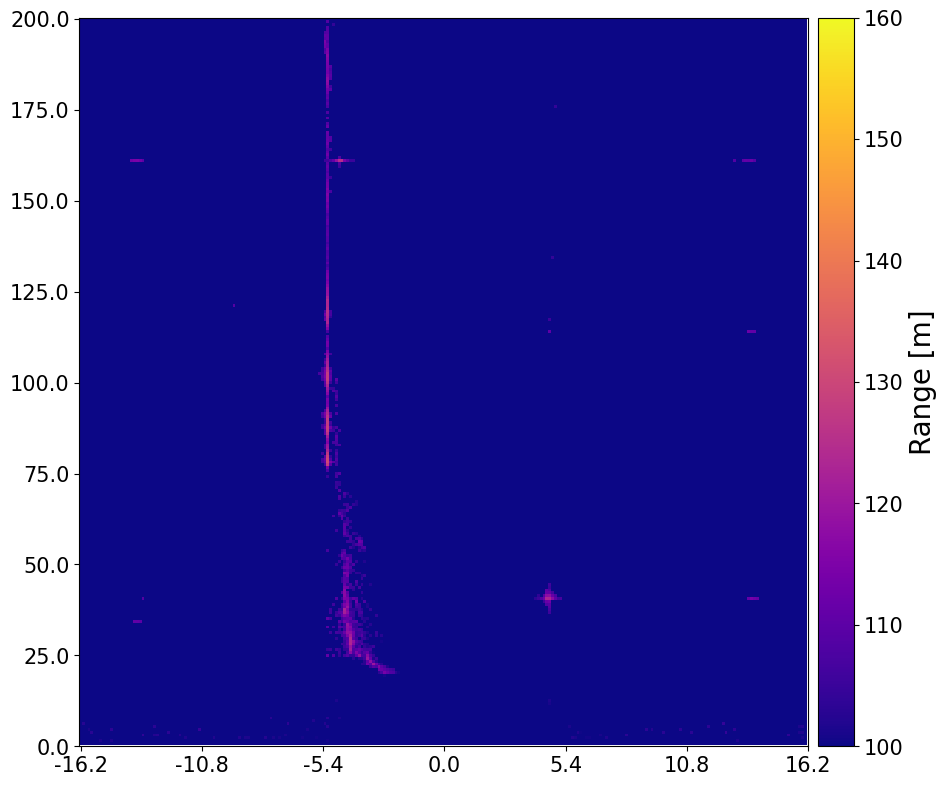

21.285585119795286
21.285585119795286


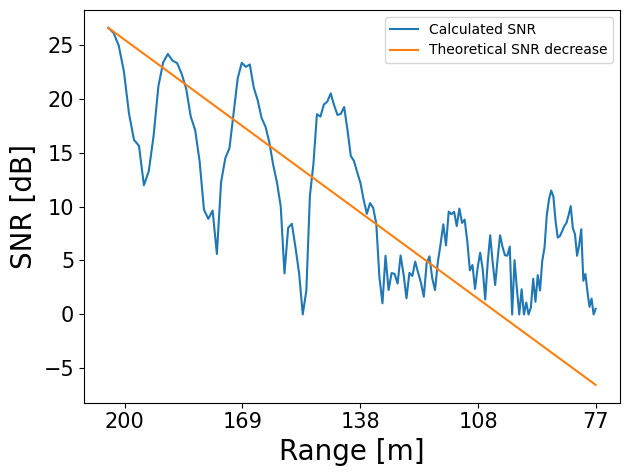

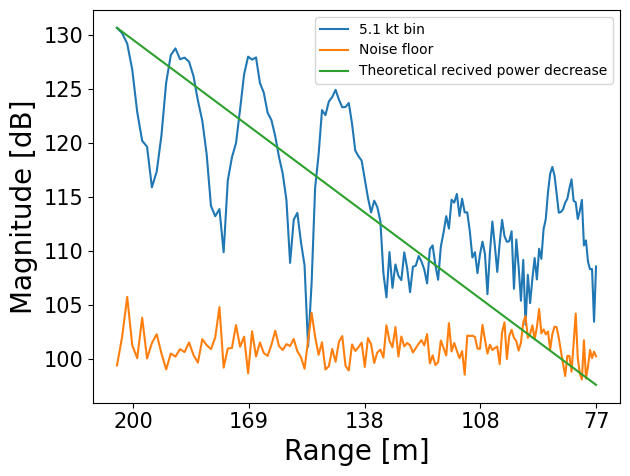

In [47]:
reflector_cfar,teflector_SNR_D,reflector_data_diff = plot_log_snr_and_PR("reflector","reflector",nr_of_ma=3,window=1,start=1,end=157,slice_start =100,slice_end=500)

# Munkholm

292916792
291867276
290817764
289768228
288718768
287669332
286619884
285570448
284520964
283471416
282421840
281372252
280322640
279273168
278223768
277174416
276125028
275075580
274026084
272976492
271926948
270877320
269827672
268778140
267728536
266678908
265629280
264579508
263529896
262480044
261430240
260380304
259330176
258280084
257229848
256179840
255129800
254079820
253029840
251979804
250929680
249879684
248829712
247779672
246729452
245679384
244629344
243579284
242529604
241479868
240430272
239380556
238330728
237281092
236231384
235181344
234131472
233081660
232031428
230981088
229931288
228881656
227831984
226782444
225732800
224683036
223633164
222583292
221533564
220483716
219433932
218384188
217334524
216284904
215235020
214185172
213135236
212085196
211035120
209985288
208935328
207885580
206835580
205785804
204735940
203685992
202636068
201586180
200536376
199486476
198436636
197386640
196336440
195286504
194236520
193186416
192136400
191085892
190035920
188985828


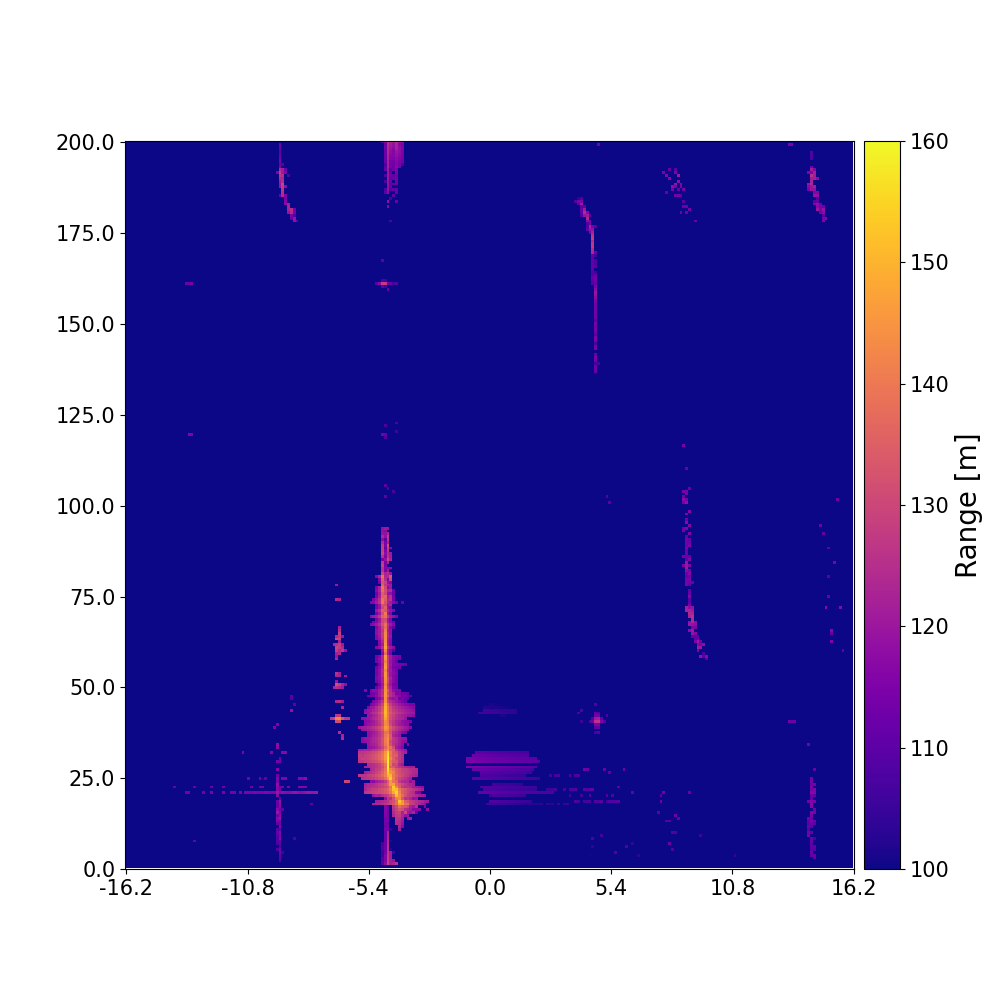

91.9386386276062
91.9386386276062


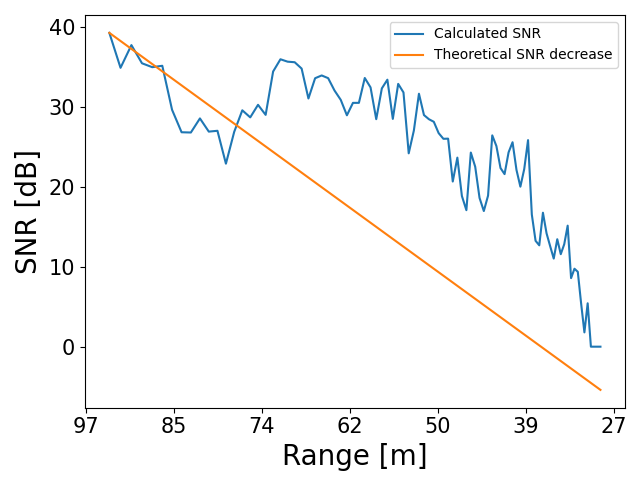

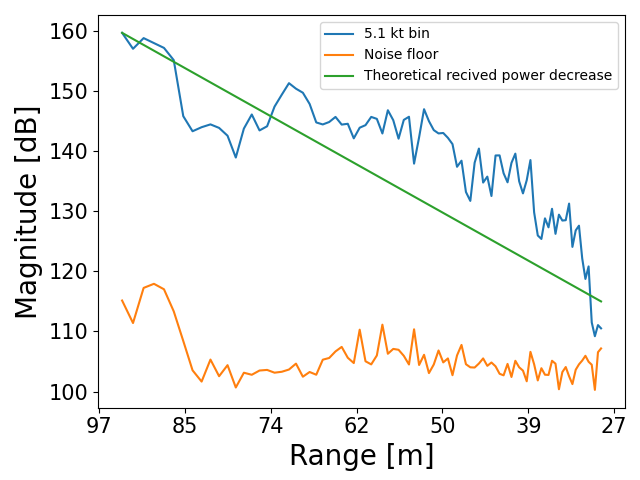

In [48]:
%matplotlib ipympl
munkholm_cfar,munkholm_SNR_D,munkholm_data_diff = plot_log_snr_and_PR("munkholm","munkholm",nr_of_ma=3,window=1,start=132,end=221,width_min=90,width_max=108,slice_start=1,slice_end=200)

(256, 256)


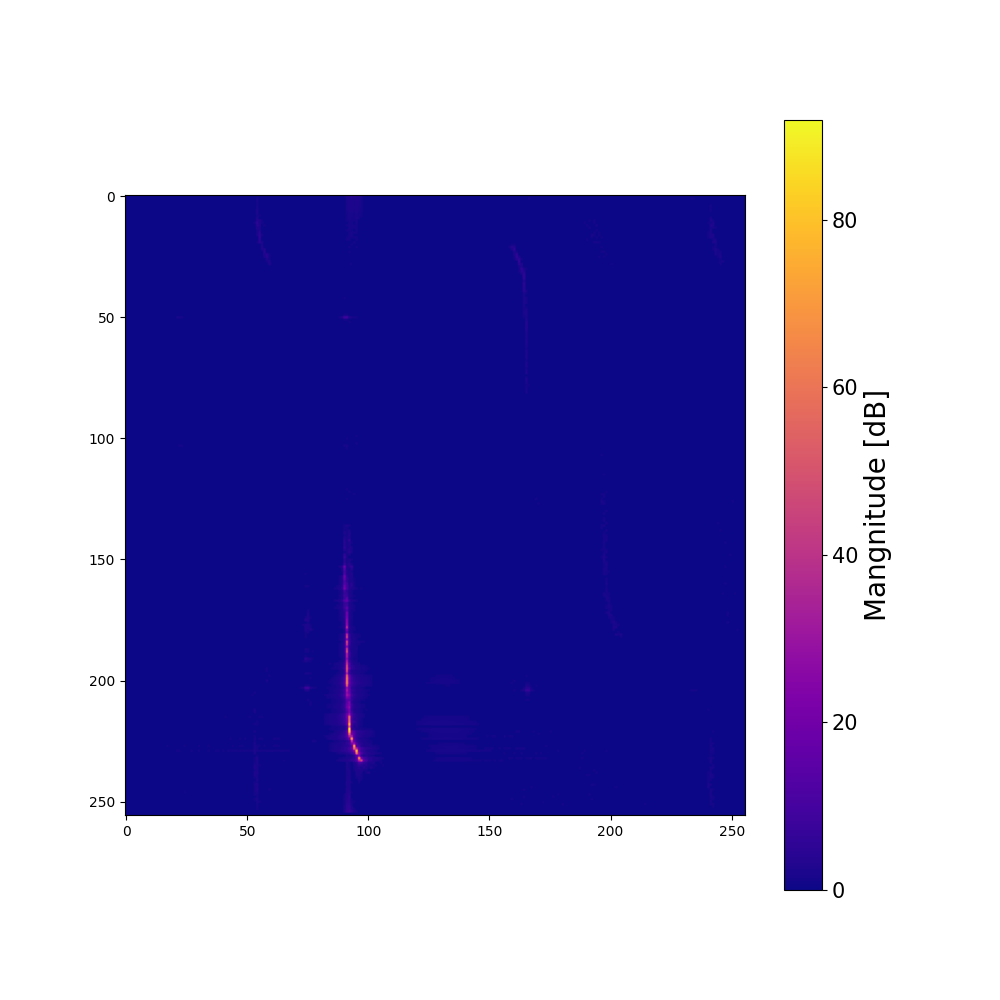

In [17]:
%matplotlib ipympl
test = np.max(np.abs(munkholm_SNR_D),axis=0)
plt.figure(figsize=(10,10))
print(np.shape(test))
rotated_img =np.abs(test) # We rotate the image so the x axis is the velocity
    
plt.imshow(rotated_img,cmap="plasma", vmin=0)
#plt.yticks(np.linspace(0,256,9),labels=np.round(np.linspace(255*0.785277,0,9)),size =15)
#plt.xticks(np.linspace(0,256,7),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size =15)
cbar  = plt.colorbar()
cbar.set_label('Mangnitude [dB]',fontdict = {'fontsize' : 20})
cbar.ax.tick_params(labelsize=15) 

plt.grid(False)

91.9386386276062
91.9386386276062


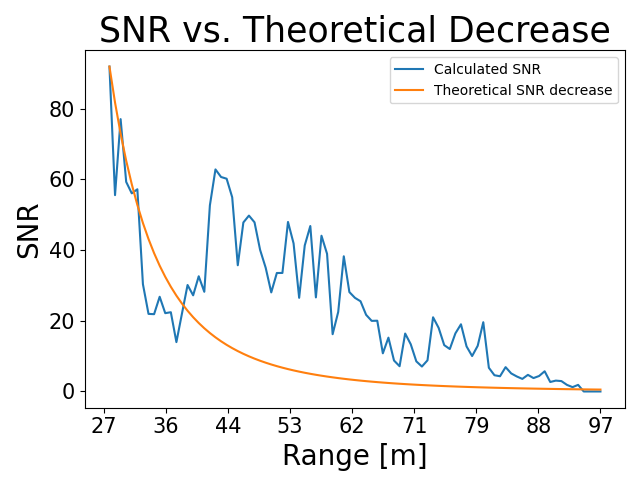

In [18]:
plt.figure()
start_bin =132
end_bin = 221

detections =np.max(np.abs(munkholm_SNR_D),axis=0)
#detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,85:108],axis=1))
#detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
print(max(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
print(max(detection_line))
plt.plot(detection_line,label="Calculated SNR")

plt.plot(r_squared,label="Theoretical SNR decrease")

plt.legend()
plt.title("SNR vs. Theoretical Decrease",size=25)
#plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("Range [m]",size=20)
plt.ylabel("SNR",size=20)
plt.tight_layout()
plt.xticks(np.linspace(0,len(detection_line),9),labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,9)),size =15)
plt.gca().invert_xaxis()

# With reflector

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


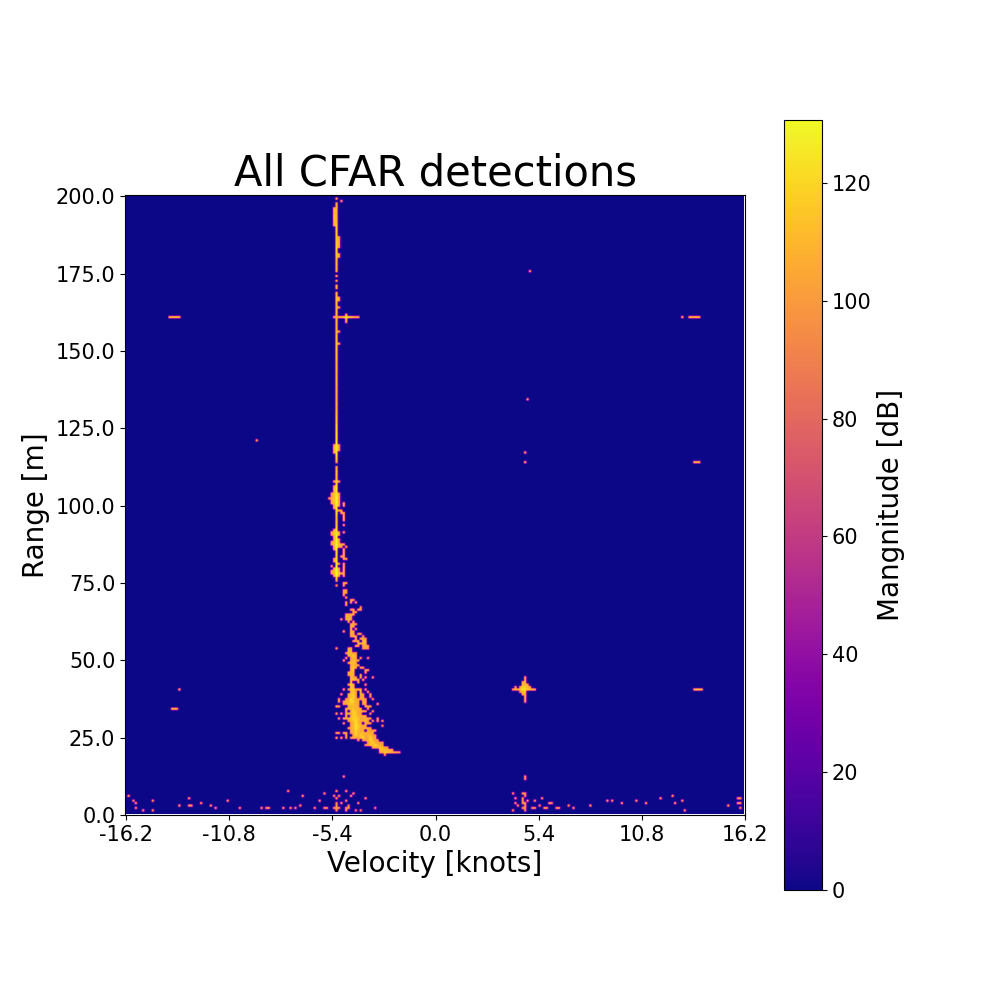

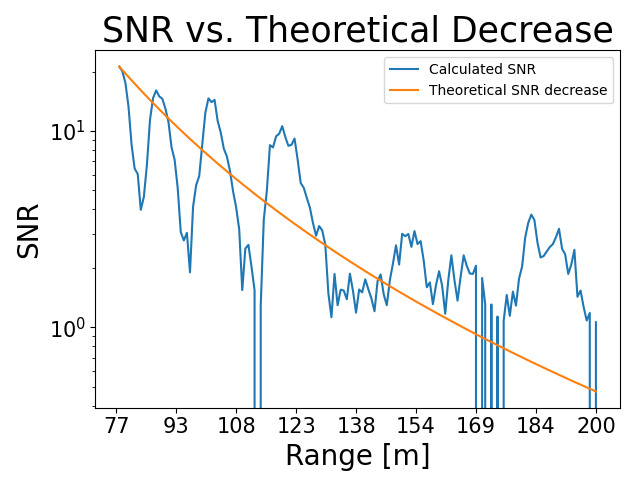

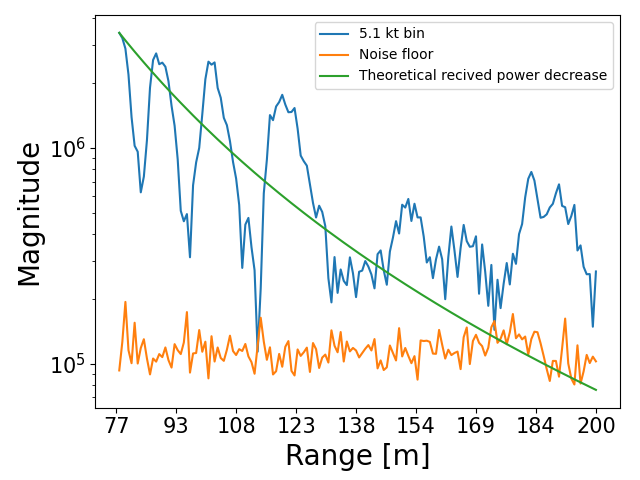

In [19]:
reflector_cfar,teflector_SNR_D,reflector_data_diff = plot_log_snr_and_PR("reflector","reflector",nr_of_ma=3,window=1,start=1,end=157,slice_start =100,slice_end=500)

In [12]:
files = {
   "no_reflector": "felttest1/Record_2022-09-27_14-34-48/Record_2022-09-27_14-34-48.bin",
    "reflector":"felttest1/Record_2022-09-27_14-14-14/Record_2022-09-27_14-14-14.bin",
    "munkholm":"felttest2/Record_2022-09-28_15-13-15/Record_2022-09-28_15-13-15.bin",
    }
try:
        #with open("felttest2/Record_2022-09-28_14-48-46/Record_2022-09-28_14-48-46.bin", "rb") as f:
        #with open("Record_2022-09-28_15-13-15.bin", "rb") as f:
        with open(files["reflector"], "rb") as f:

            data = f.read()
        
            
            
except IOError as e:
        print(e)

stri = "DONE"
done = False
data_arr = []
index = 0
data_bytes = data
while(not done):
        ls = re.search(stri.encode(), data_bytes).end()
        data_arr.append(data_bytes[:ls])
        data_bytes = data_bytes[ls+4:]
        print(len(data_bytes))
        if(len(data_bytes) == 0):
            done = True

725850672
724801916
723753136
722704392
721655612
720606868
719558112
718509392
717460660
716411904
715363148
714314380
713265588
712216796
711168028
710119236
709070456
708021664
706972884
705924116
704875336
703826556
702777764
701728996
700680192
699631364
698582548
697533708
696484880
695436064
694387248
693338480
692289712
691240944
690192152
689143360
688094604
687045860
685997104
684948312
683899532
682850776
681802008
680753264
679704520
678655776
677606960
676558156
675509412
674460620
673411828
672363072
671314304
670265548
669216780
668168012
667119232
666070428
665021624
663972784
662923992
661875224
660826396
659777604
658728824
657680056
656631300
655582532
654533752
653484972
652436204
651387424
650338680
649289924
648241156
647192424
646143668
645094900
644046132
642997328
641948536
640899756
639850940
638802148
637753368
636704552
635655748
634606992
633558212
632509384
631460580
630411788
629362984
628314180
627265352
626216560
625167780
624118940
623070116
622021256


In [20]:
data_ma,raw_t,data_diff = background_update(data_arr,nr_of_ma=
        3, alpha=1/256,window = 1)    

MA 0
MA 1
MA 2


In [27]:
start=1
end=157
width_min=86
width_max=90

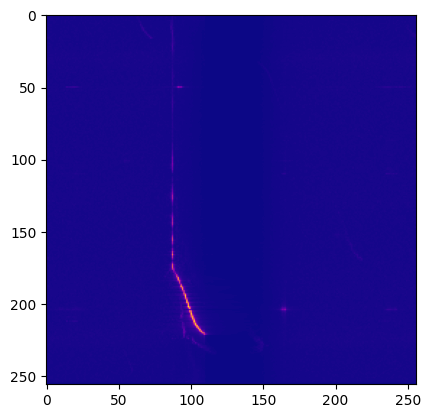

In [28]:
plt.imshow(ndimage.rotate(np.max(np.abs(data_diff),axis=0),90),cmap="plasma",)

(array([18., 19., 20., 21., 22., 23., 24.]), [Text(18.0, 0, '18'), Text(19.0, 0, '19'), Text(20.0, 0, '20'), Text(21.0, 0, '21'), Text(22.0, 0, '22'), Text(23.0, 0, '23'), Text(24.0, 0, '24')])


([<matplotlib.axis.XTick at 0x7fec115c69d0>,
 [Text(19.0, 0, '200'),
  Text(20.0, 0, '169'),
  Text(21.0, 0, '138'),
  Text(22.0, 0, '108'),
  Text(23.0, 0, '77')])

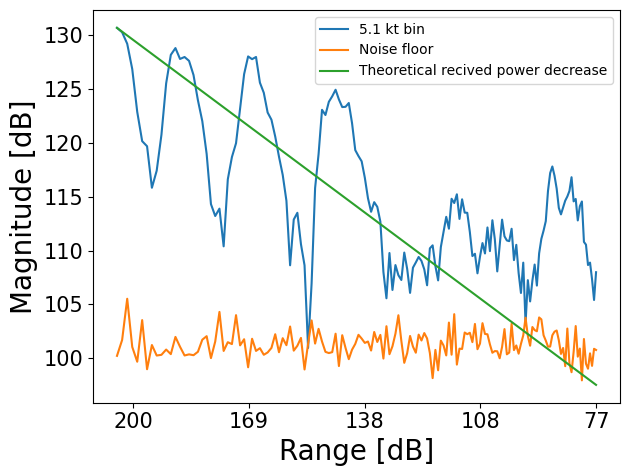

In [44]:
  ### plot PR_loss
plt.figure()
start_bin =start
end_bin = end

detections =np.max(np.abs(data_diff),axis=0)
detections  = ndimage.rotate(detections,90)
detection_line = np.abs(np.max(detections[start_bin:end_bin,width_min:width_max],axis=1))
    #detection_line = np.abs(detections[start_bin:end_bin,87])

r = np.linspace((255-start_bin)*0.785277,(255-end_bin)*0.785277,len(detection_line))
r_squared =max(detection_line)/(r/((255-end_bin)*0.785277))**4
     
plt.plot(10*np.log10(r),20*np.log10(detection_line),label="5.1 kt bin")
plt.plot(10*np.log10(r),20*np.log10(np.abs(detections[start_bin:end_bin,50])),label="Noise floor")

plt.plot(10*np.log10(r),20*np.log10(r_squared),label="Theoretical recived power decrease")
#plt.plot(detection_line,label="5.1 kt bin")
#plt.plot(np.abs(detections[start_bin:end_bin,50]),label="Noise floor")
#plt.gca().invert_xaxis()
#plt.plot(r_squared,label="Theoretical recived power decrease")

plt.legend()
    #plt.title("",size=25)
    #plt.xticks(np.linspace(0,157,1),labels=np.round(np.linspace(-0.127552440715*127,0.127552440715*127,7),2),size=15)
plt.yticks(size=15)
plt.xlabel("Range [dB]",size=20)
plt.ylabel("Magnitude [dB]",size=20)
plt.tight_layout()
x_ticks = plt.xticks()
print(x_ticks)
plt.xticks(x_ticks[0][1:-1] ,labels=np.int16(np.linspace((256-start_bin)*0.785277,(256-end_bin)*0.785277,len(x_ticks[0] )-2)),size =15)

#plt.savefig(f"SNR_plots/{save_filename}_pr.svg",format="svg")